In [26]:
import pandas as pd
from datetime import datetime, timedelta, date
import time
import matplotlib.pyplot as plt
from typing import List


#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

# Historical Quotes. The most updated start on 2024-08-04
# Lets use 6 months for historical data
quotes_start_date = date(2024, 1, 4)
df_quotes = pd.read_csv("ft_quotes.csv",index_col=0,parse_dates=True).sort_index(ascending=True).ffill().dropna(axis=1).loc[date(2023, 8, 4):]
df_quotes.index = [x.date() for x in df_quotes.index]


# Portofolio on Quotes Start Date
inital_amount = 100
encoding='latin_1'
thousands = ','
decimal = '.'
to_date = lambda d: datetime.strptime(d, '%d-%m-%Y').date()
transacoes_csv = 'transacoes.csv'
converters={'Data de subscricao': to_date}
df_transacoes = pd.read_csv(transacoes_csv ,sep=',',encoding=encoding,thousands=thousands, decimal=decimal, converters=converters, dtype={'Cotacao de Subscricao':float,'Quantidade':float})
df_transacoes['Data de resgate'] = df_transacoes['Data de resgate'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date() if pd.notnull(x) else x)
df_transacoes = df_transacoes[df_transacoes['Code'].isin(df_quotes.columns)]
filter = (df_transacoes['Data de subscricao']<=quotes_start_date) & ((pd.isnull(df_transacoes['Data de resgate'])) | (df_transacoes['Data de resgate']>quotes_start_date))
df_transacoes = df_transacoes[filter]
df_transacoes['Amount'] = df_transacoes.apply(lambda x: x['Quantidade']*df_quotes[x['Code']][quotes_start_date] * (exchange_rates.loc[quotes_start_date] if x['Moeda'] == 'USD' else 1), axis=1)
df_portofolio = df_transacoes.groupby('Code')['Amount'].sum()
df_portofolio = df_portofolio * inital_amount  / df_portofolio.sum()

# Parameters
risk_free_rate = 0.03

amount_to_buy = 20
amount_to_sell = 20
final_portfolio_amount = inital_amount + amount_to_buy - amount_to_sell
transaction_amount = 2

n_funds_to_add = 6
max_weight = 0.09

In [8]:
# Select relevant funds
df_perform = pd.read_csv("ft_funds_perform.csv", index_col=0)
relevant_funds = set(df_perform[df_perform['currency'].isin(["EUR","USD"])].index)
relevant_funds &= set([idx for idx in df_perform.index if not idx.startswith("PT")])
relevant_funds &= set(df_quotes.columns)

len(relevant_funds)

3063

In [9]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

### Portfolio Optimization Functions

In [16]:
def new_fund_performance(new_portfolio, new_fund, amount=transaction_amount, risk_free_rate=risk_free_rate, last_n=15, goal='max_sharpe',target=None,weight_bounds = (0,1)):
    if new_fund in new_portfolio.index:
        new_portfolio.loc[new_fund] += amount
    else:
        new_portfolio.loc[new_fund] = amount

    mu = mean_historical_return(df_quotes[new_portfolio.index][-last_n:])
    S = CovarianceShrinkage(df_quotes[new_portfolio.index][-cov_n:]).ledoit_wolf()
    ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds, solver='SCS')
    if goal=='max_sharpe':
        ef.max_sharpe(risk_free_rate=risk_free_rate)
    elif goal=='min_volatility':
        ef.min_volatility()
    elif goal=='efficient_risk':
        ef.efficient_risk(target_volatility=target)
    elif goal=='efficient_return':
        ef.efficient_return(target_return=target)
    else:
        raise ValueError('Invalid Goal!')
    return new_portfolio, ef.portfolio_performance(risk_free_rate=risk_free_rate)

def new_funds_to_add(df_portofolio, selected_funds, n_funds_to_add, last_n, goal, target=None, verbose=False, weight_bounds = (0,1)):

    mu = mean_historical_return(df_quotes[df_portofolio.index][-last_n:])
    S = CovarianceShrinkage(df_quotes[df_portofolio.index][-cov_n:]).ledoit_wolf()

    ef = EfficientFrontier(mu, S, solver='SCS')
    weights = df_portofolio / df_portofolio.sum()
    ef.set_weights(weights)

    current_return, current_volatility, current_sharpe_ratio = ef.portfolio_performance(risk_free_rate=risk_free_rate)

    max_sharpe = current_sharpe_ratio
    min_volatility = current_volatility
    amount = transaction_amount
    funds_to_buy = []
    performance = None

    current_portfolio = df_portofolio.copy()
    for i in range(n_funds_to_add):
        best_fund = None
        for new_fund in selected_funds:
            try:
                _, (new_return,new_volatility,new_sharpe) = new_fund_performance(
                                                    new_portfolio=current_portfolio.copy(),
                                                    new_fund=new_fund,
                                                    last_n=last_n,
                                                    goal=goal,
                                                    target=target)
                if ((goal == 'max_sharpe') or (goal == 'efficient_risk')) and (new_sharpe > max_sharpe):
                    max_sharpe = new_sharpe
                    best_fund = new_fund
                if ((goal == 'min_volatility') or (goal == 'efficient_return')) and (new_volatility < min_volatility):
                    min_volatility = new_volatility
                    best_fund = new_fund
            except Exception as e:
                raise e
                pass
        
        if best_fund is None:
            print("\nNo more Funds found!")
            break
        else:
            funds_to_buy.append(best_fund)
            current_portfolio, performance = new_fund_performance(
                new_portfolio=current_portfolio,
                new_fund=best_fund,
                last_n=last_n,
                goal=goal,
                target=target)
            if verbose:
                print("### Performance with ", best_fund)
                print(df_perform.loc[best_fund][['ft category','name']])
                print(performance)
    return funds_to_buy, performance

def portfolio_strategy(dfi, ef, prev_strategy=None):
    cleaned_weights = ef.clean_weights()
    cleaned_weights = [(s,w) for s,w in cleaned_weights.items()]
    dfo = pd.DataFrame(cleaned_weights,columns=['Code','w']).sort_values(by='w',ascending=False)
    df = pd.merge(dfi,dfo,on=['Code'],how='outer',suffixes=('_i','_o')).fillna(0)
    if prev_strategy is not None:
        df['strategy'] =  df.apply(lambda x: prev_strategy.loc[x['Code']]['strategy'], axis=1)
    else:
        df['strategy'] = 'c'
    df['final_amount'] = df.apply(lambda x: x['amount'] if x['strategy']=='k' else x['w_o']*final_portfolio_amount, axis=1)
    df['change_amount'] = df['final_amount'] - df['amount']

    return df

In [11]:
def valid_date(d: date) -> date:
    if d in df_quotes.index:
        return d
    return max(dd for dd in df_quotes.index if dd <= d)

def next_date(current_date: date, transaction_interval: int = 7) -> date:
    return valid_date(current_date + timedelta(days=transaction_interval))

def fund_selection_1(current_date: date) -> set:
    old_date = valid_date(quotes_start_date - timedelta(days=14))
    df_perform['2w'] = df_quotes.loc[current_date]/df_quotes.loc[old_date]
    selected_funds = set(df_perform[df_perform.groupby('ft category')['2w'].transform('max')==df_perform['2w']].index)
    selected_funds |= set(df_perform[df_perform['rating'] >= 5].index)
    return selected_funds & relevant_funds

In [42]:
transaction_limit = 1

In [ ]:
last_n = 21
cov_n = 153

mu = mean_historical_return(df_quotes[df_portofolio.index].loc[valid_date(quotes_start_date - timedelta(days=last_n)):current_date])
S = CovarianceShrinkage(df_quotes[df_portofolio.index].loc[valid_date(quotes_start_date - timedelta(days=cov_n)):current_date]).ledoit_wolf()
ef = EfficientFrontier(mu, S, solver='SCS')
weights = df_portofolio / df_portofolio.sum()
ef.set_weights(weights)
dfi = pd.DataFrame({'w':weights, 'amount':df_portofolio}).reset_index().sort_values(by='w',ascending=False)

new_portfolio = df_portofolio.copy()

current_date = valid_date(d=quotes_start_date)

funds_to_buy, performance = new_funds_to_add(
    df_portofolio=new_portfolio,
    selected_funds=fund_selection_1(current_date=current_date), 
    n_funds_to_add=n_funds_to_add,
    last_n=last_n,
    goal='max_sharpe',
    verbose=True,
    weight_bounds=(0,max_weight))

new_p = new_portfolio.index.append(pd.Index(funds_to_buy))

mu = mean_historical_return(df_quotes[new_p].loc[valid_date(quotes_start_date - timedelta(days=last_n)):current_date])
S = CovarianceShrinkage(df_quotes[new_p].loc[valid_date(quotes_start_date - timedelta(days=cov_n)):current_date]).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=(0,max_weight), solver='SCS')
ef.max_sharpe(risk_free_rate=risk_free_rate)

df = portfolio_strategy(dfi=dfi,ef=ef).set_index('Code')

In [47]:
df

,w_i,amount,w_o,strategy,final_amount,change_amount
Code,,,,,,
LU1244139660,0.087470,8.746987,0.00000,c,0.000,-8.746987
LU0173776047,0.068550,6.855046,0.01515,c,1.515,-5.340046
IE00BLP5S460,0.059409,5.940854,0.07870,c,7.870,1.929146
LU0705071453,0.053763,5.376330,0.09000,c,9.000,3.623670
FR0000989915,0.052567,5.256685,0.00000,c,0.000,-5.256685
LU0286668966,0.051108,5.110807,0.00000,c,0.000,-5.110807
LU1495982271,0.049214,4.921364,0.07788,c,7.788,2.866636
LU1373035150,0.046716,4.671644,0.00000,c,0.000,-4.671644
LU1915690918,0.045846,4.584617,0.05405,c,5.405,0.820383


In [50]:
weight_bounds = list()
buy_list = list()
for i, code in enumerate(df_quotes[new_p].columns):
    if abs(df.loc[code]['change_amount']) < transaction_limit:
        weight_bounds.append((df.loc[code]['w_i'],df.loc[code]['w_i'])) # Keep
    elif df.loc[code]['change_amount'] >= 0.0:
        weight_bounds.append((df.loc[code]['w_i'],max_weight)) # keep or buy
    else:
        weight_bounds.append((0.0,df.loc[code]['w_i'])) #keep or sell
    if df.loc[code]['change_amount'] >= 0.0:
        buy_list.append((i,df.loc[code]['w_i']))


In [51]:
mu = mean_historical_return(df_quotes[new_p].loc[valid_date(quotes_start_date - timedelta(days=last_n)):current_date])
S = CovarianceShrinkage(df_quotes[new_p].loc[valid_date(quotes_start_date - timedelta(days=cov_n)):current_date]).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds, solver='SCS')
# Limit the amount to buy
buy_final_w = (sum([w_i for _,w_i in buy_list])*inital_amount + amount_to_buy) / final_portfolio_amount
ef.add_constraint(lambda x : sum([x[i] for i,_ in buy_list]) == buy_final_w)
ef.max_sharpe(risk_free_rate=risk_free_rate)

df = portfolio_strategy(dfi=dfi,ef=ef).set_index('Code')
df['w_o'] = df.apply(lambda x: x['w_i'] if abs(x['change_amount'])<transaction_limit else x['w_o'], axis = 1)
r = 1- (df['w_o'].sum()-1) / df[(df['w_o']!=df['w_i'])]['w_o'].sum()
df['w_o'] = df.apply(lambda x: x['w_o']*(1 if x['w_o']==x['w_i'] else r) ,axis=1)

,w_i,amount,w_o,strategy,final_amount,change_amount
Code,,,,,,
LU1244139660,0.087470,8.746987,0.00000,c,0.000,-8.746987
LU0173776047,0.068550,6.855046,0.06855,c,6.855,-0.000046
IE00BLP5S460,0.059409,5.940854,0.05941,c,5.941,0.000146
LU0705071453,0.053763,5.376330,0.09000,c,9.000,3.623670
FR0000989915,0.052567,5.256685,0.00071,c,0.071,-5.185685
LU0286668966,0.051108,5.110807,0.05111,c,5.111,0.000193
LU1495982271,0.049214,4.921364,0.04921,c,4.921,-0.000364
LU1373035150,0.046716,4.671644,0.04672,c,4.672,0.000356
LU1915690918,0.045846,4.584617,0.04585,c,4.585,0.000383


In [ ]:

while current_date = < df_quotes.index.max():
    
    funds_to_buy, performance = new_funds_to_add(
        df_portofolio=new_portfolio,
        selected_funds=fund_selection_1(current_date=current_date), 
        n_funds_to_add=n_funds_to_add,
        last_n=last_n,
        goal='max_sharpe',
        target=target_return,
        verbose=True,
        weight_bounds=(0,max_weight))

    new_p = new_portfolio.index.append(pd.Index(funds_to_buy))

    mu = mean_historical_return(df_quotes[new_p][-last_n:])
    S = CovarianceShrinkage(df_quotes[new_p][-cov_n:]).ledoit_wolf()
    ef = EfficientFrontier(mu, S, weight_bounds=(0,max_weight), solver='SCS')
    ef.efficient_return(target_return=target_return)

    df = portfolio_strategy(dfi=dfi,ef=ef)


    current_date = next_date(current_date =)
    
    


305

### Create the initial Strategy

### Performance with  LU0171305443
ft category                     Sector Equity Financial Services
name           BlackRock Global Funds - World Financials Fund...
Name: LU0171305443, dtype: object
(0.7651554351655508, 0.02054095918356441, 35.9114405794534)
### Performance with  LU0628613639
ft category                      Sector Equity Natural Resources
name           BlackRock Global Funds - Natural Resources Gro...
Name: LU0628613639, dtype: object
(0.8065205200569427, 0.021153047321840653, 36.82781531210396)
### Performance with  LU0428380397
ft category                     Systematic Trend USD
name           Man AHL Trend Alternative DNY USD Acc
Name: LU0428380397, dtype: object
(0.8824727077707888, 0.022842806736706644, 37.42853133704069)
Expected annual return: 50.0%
Annual volatility: 1.4%
Sharpe Ratio: 34.76


,Code,w_i,name,amount,w_o,strategy,final_amount,change_amount
0,LU1915690918,0.085776,Nordea Eu Cov Bond Op,25393.279100,0.02011,c,6053.960952,-19339.318148
4,LU0966156399,0.059632,Fidelity Fast Global,17653.575600,0.01511,c,4548.749378,-13104.826222
11,LU0563745743,0.043147,Bestinver Tordesillas Iberia A,12773.415677,0.00241,c,725.511979,-12047.903698
13,LU0705071453,0.040114,RAM System Long/Short Europ B,11875.517820,0.00995,c,2995.371033,-8880.146787
17,LU0414665884,0.020191,BSF European Absolut Ret E2,5977.498800,0.00115,c,346.198662,-5631.300138
19,LU1244139660,0.017390,TRP Glb Technology,5148.083805,0.00000,c,0.000000,-5148.083805
7,LU0627762692,0.049854,BlueBay Bond R,14758.755996,0.03533,c,10635.824985,-4122.931011
14,LU0390137973,0.036965,Templeton Frontier Markets,10943.281440,0.02400,c,7225.015557,-3718.265883
22,LU0496369116,0.012311,Franklin Gold Precious Metals,3644.566174,0.00000,c,0.000000,-3644.566174
12,LU0627762007,0.041823,BlueBay Bond R EUR,12381.298080,0.03069,c,9238.988644,-3142.309436


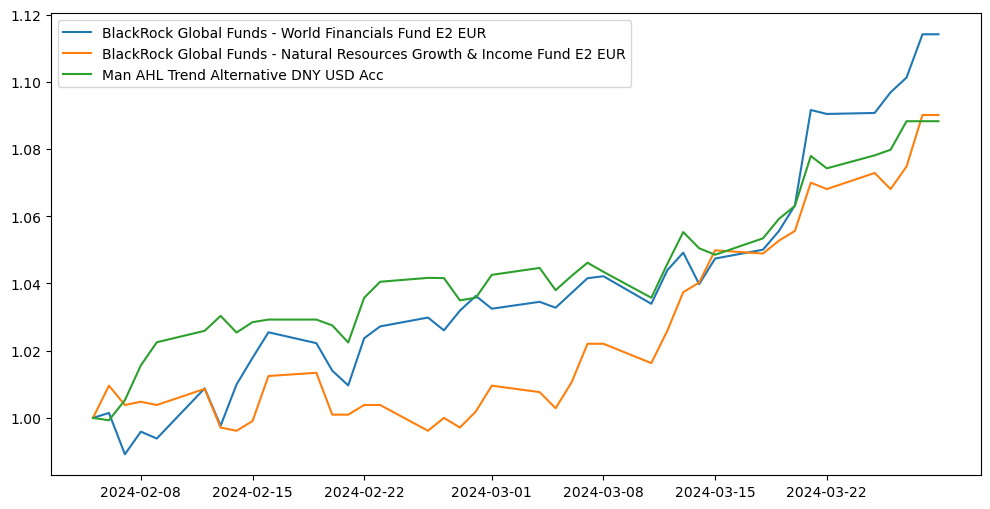

In [ ]:
#ignore_funds = ['FR0010109165','LU0828815224']
#selected_funds = [x for x in selected_funds if x not in ignore_funds]
#####  Get the funds for the target volatility
funds_to_buy, performance = new_funds_to_add(
    df_portofolio=new_portfolio,
    selected_funds=selected_funds, 
    n_funds_to_add=n_funds_to_add,
    last_n=last_n,
    #goal='efficient_return',
    #goal='min_volatility',
    goal='max_sharpe',
    target=target_return,
    verbose=True,
    weight_bounds=(0,max_weight))

new_p = new_portfolio.index.append(pd.Index(funds_to_buy))

mu = mean_historical_return(df_quotes[new_p][-last_n:])
S = CovarianceShrinkage(df_quotes[new_p][-cov_n:]).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=(0,max_weight), solver='SCS')
ef.efficient_return(target_return=target_return)

df = portfolio_strategy(dfi=dfi,ef=ef)

df.sort_values('Code',ascending=False).to_csv('portfolio_changes_strategy.csv',index=False)
ef.portfolio_performance(verbose=True,risk_free_rate=risk_free_rate)
df_plot = df_quotes[pd.Index(funds_to_buy)][-40:]
ax = df_plot.apply(lambda x: x/df_plot.iloc[0],axis=1).rename(columns=df_perform['name']).sort_values(by=df_plot.index.max(), axis='columns', ascending=False).plot(figsize=(12,6))
ax.legend(loc='upper left')
ax.plot()
df.sort_values('change_amount')